# Exploring spatio-temporal travel patterns of bike-sharing and forecasting demand using time-series analysis methods by machine learning: the case of Chicago

2909640X

06.04.2024

In [2]:
import requests
import pandas as pd
import numpy as np

from bs4 import BeautifulSoup
import zipfile
import os

import pyarrow.parquet as pq
import seaborn as sns
import contextily as ctx
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point, Polygon
import geoplot

import mapclassify as mc
from scipy.stats import kurtosis, skew
from PIL import Image

import warnings
# Ignore warning messages
warnings.filterwarnings('ignore')

In [8]:
%%html
<style>
img {
    display: block;
    margin-left: auto;
    margin-right: auto;
}
</style>

## 1. Introduction
Bike-sharing trips have been receiving widespread attention as a green travelling mode, with bike-sharing systems appearing in more and more cities (Guidon, Reck and Axhausen, 2020, p. 1). The widespread use of bike-sharing can improve urban transport connectivity and gain environmental benefits (E, Park and Cho, 2020, pp. 1-2). However, the actual demand for bike-sharing trips is affected by a variety of factors such as time, weather, urban spatial environment, public transport, etc., and is not balanced in temporal and spatial distributions, and the actual benefits of use are reduced as a result (Eren and Uz, 2020; Lin et al., 2024).

Studying the travel patterns of bike-sharing and forecasting the demand for its use is important for improving the use of bikes and optimising the urban transport system. This study aims to answer the following questions: (1) What are the temporal and spatial characteristics of bike-sharing travel patterns? (2) What are the factors affecting the demand for bike-sharing and to what extent? (3) How to forecast the demand for bike-sharing?

## 2. Study area and data
### 2.1 Study Area
The study area for this research is Chicago City in the US. Fig. 1. shows our study area and the distribution of bike-sharing stations. Chicago is considered to be one of the most cycling-friendly cities in the US. Divvy, Chicago's bicycle-sharing system (BSS), was launched in 2013 and has evolved into one of the most successful BSSs within the US, providing a fun and convenient way for citizens to travel (Bergman, Allenspach and Bergman, 2024, p.2). The long history of BBS operations, the broad range of services, and the historical travel datasets available to the public make Chicago an ideal location for bike-sharing research.


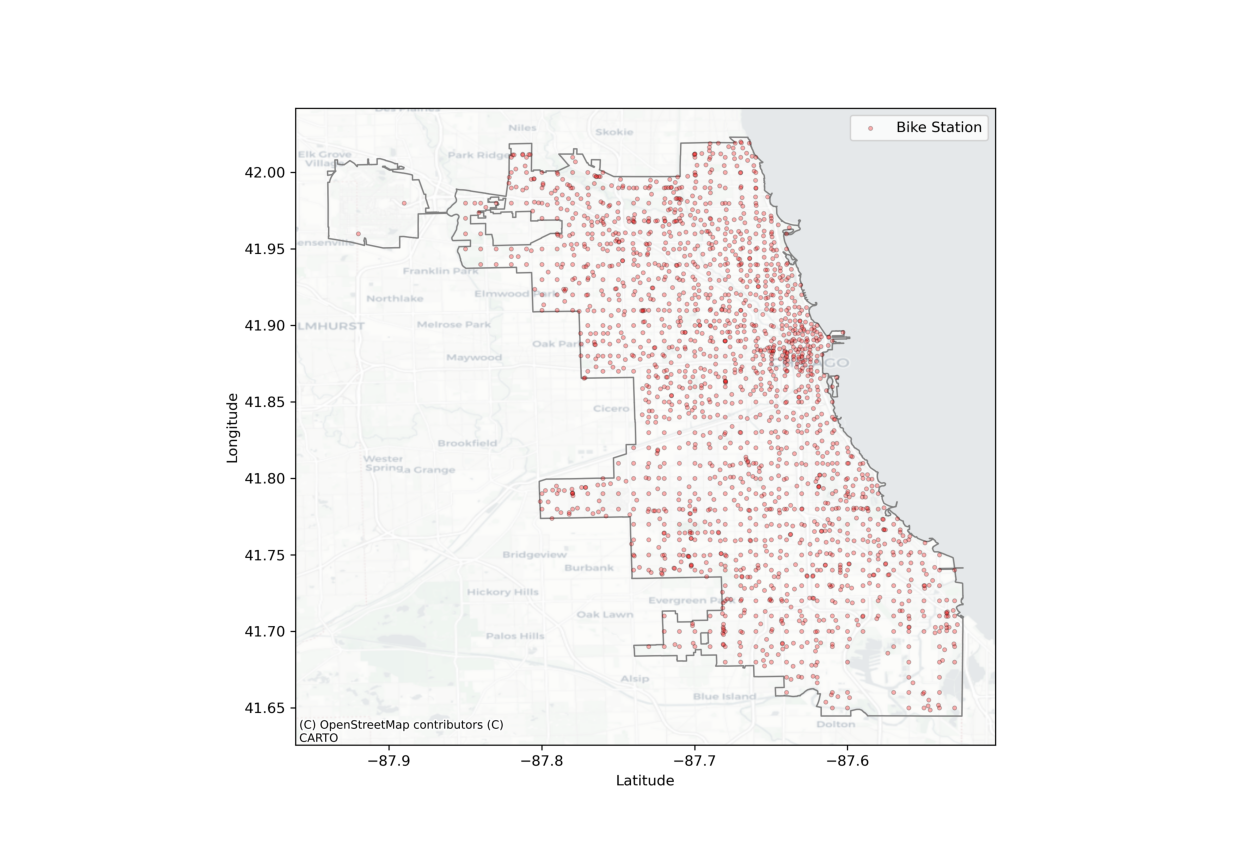

In [6]:
plt.figure(figsize=(16,16))
Fig_1 = Image.open('figure/Fig 1.png')
plt.imshow(Fig_1)
plt.axis('off')  
plt.show()

Fig. 1. Study area and bike-sharing station distribution

### 2.2 Data 
This study used a trip history dataset of bike-sharing provided by Divvy (2024), Metra Rail Station, Bus Stop, and City Boundary data from the Chicago Metropolitan Agency for Planning (2024), and meteorological data obtained from NASA POWER (2024).
### 2.2.1 Bike-sharing Trip History Dataset
The dataset contains a wealth of information about the ride trips, including unique ride ID, vehicle type, date and time of the start and end of the trip, name, ID, and geographic coordinates of the trip's start and end stops, and passenger classification (Divvy bikes, 2024). Specific information can be seen in Table 1. The data is anonymised before release and any trips made by staff and any trips less than 60 seconds in length are eliminated, ensuring the validity of the data (Divvy bikes, 2024).

The data is updated on a monthly basis and is time-sensitive. We retrieved and obtained a total of 60,879,914 trip records for the period January 2023 to February 2024 by sending GET requests to the URL of the website and parsing the HTML content using the BeautifulSoup package.

In [4]:
bike_original = pd.read_csv("raw data/bike_raw.csv")
bike_original.head()

ride_id  rideable_type           started_at             ended_at  \
0  F96D5A74A3E41399  electric_bike  2023-01-21 20:05:42  2023-01-21 20:16:33   
1  13CB7EB698CEDB88   classic_bike  2023-01-10 15:37:36  2023-01-10 15:46:05   
2  BD88A2E670661CE5  electric_bike  2023-01-02 07:51:57  2023-01-02 08:05:11   
3  C90792D034FED968   classic_bike  2023-01-22 10:52:58  2023-01-22 11:01:44   
4  3397017529188E8A   classic_bike  2023-01-12 13:58:01  2023-01-12 14:13:20   

            start_station_name start_station_id  \
0  Lincoln Ave & Fullerton Ave     TA1309000058   
1        Kimbark Ave & 53rd St     TA1309000037   
2       Western Ave & Lunt Ave           RP-005   
3        Kimbark Ave & 53rd St     TA1309000037   
4        Kimbark Ave & 53rd St     TA1309000037   

                 end_station_name end_station_id  start_lat  start_lng  \
0       Hampden Ct & Diversey Ave       202480.0  41.924074 -87.646278   
1         Greenwood Ave & 47th St   TA1308000002  41.799568 -87.594747   
2  Valli Produce - Evanston Plaza            599  42.008571 -87.690483   
3         Greenwood Ave & 47th St   TA1308000002  41.799568 -87.594747   
4         Greenwood Ave & 47th St   TA1308000002  41.799568 -87.594747   

     end_lat    end_lng member_casual     REF  
0  41.930000 -87.640000        member  202301  
1  41.809835 -87.599383        member  202301  
2  42.039742 -87.699413        casual  202301  
3  41.809835 -87.599383        member  202301  
4  41.809835 -87.599383        member  202301

Table 1. Example of the trip raw data table

### 2.2.2 Public transport stations and city boundary
Based on the city boundary the trips outside the study area can be eliminated. The public transport station dataset contains information such as station name, coordinates, etc. After excluding the data outside the study area, we get 73 metro stations and 5788 bus stations, and we can obtain their relative positional relationship with bike-sharing stations.

In [9]:
BusStop = pd.read_csv("raw data/BusStop_unique.csv")
BusStop.head()

Station_name  longitude   latitude  \
0       East River Rd & Carmen -87.846583  41.971303   
1       East River Rd & Berwyn -87.846407  41.974865   
2       East River Rd & Foster -87.846405  41.973622   
3  East River Rd & Evelyn Lane -87.846369  41.976722   
4           Lawrence & Oakview -87.844002  41.966354   

                                  geometry      type  
0  POINT (-87.84658291700001 41.971302724)  Bus stop  
1          POINT (-87.846407001 41.974865)  Bus stop  
2     POINT (-87.84640500099999 41.973622)  Bus stop  
3        POINT (-87.846369463 41.97672168)  Bus stop  
4       POINT (-87.844002045 41.966353552)  Bus stop

In [10]:
Metro = pd.read_csv("raw data/MetroStation_unique.csv")
Metro.head()

Station_name                                     geometry  longitude  \
0   Edison Park   POINT (-87.8177129145889 42.0022385752373) -87.817713   
1    Mont Clare  POINT (-87.80116061986929 41.9216441167462) -87.801161   
2  Norwood Park   POINT (-87.7990648711145 41.9917578463734) -87.799065   
3          Mars   POINT (-87.7945391419177 41.9192605892427) -87.794539   
4      Galewood   POINT (-87.78473968774161 41.916405576911) -87.784740   

    latitude           type  
0  42.002239  Metro Station  
1  41.921644  Metro Station  
2  41.991758  Metro Station  
3  41.919261  Metro Station  
4  41.916406  Metro Station

Table 2. Examples of metro and bus station datasheet

### 2.2.3 Meteorological data
Using the Application Programming Interface (API) provided by NASA POWER, we can obtain meteorological time series data at the hourly level. After specifying the relevant parameters, we get the meteorological parameters including temperature, total precipitation, relative humidity, wind speed, and barometric pressure for the period of January 2023 to March 2024 in Chicago. We can link them to the bike-sharing trip data by time.


In [11]:
Weather = pd.read_csv("raw data/Weather_cleaned.csv")
Weather.head()

Timestamp  Year  Month  Day  Hour  Temp     Atemp  Prec  \
0  2022-12-31 18:00:00  2022     12   31    18  1.59  2.356667  0.00   
1  2022-12-31 19:00:00  2022     12   31    19  1.86  2.356667  0.00   
2  2022-12-31 20:00:00  2022     12   31    20  2.48  2.356667  0.00   
3  2022-12-31 21:00:00  2022     12   31    21  2.84  2.356667  0.00   
4  2022-12-31 22:00:00  2022     12   31    22  2.80  2.356667  0.02   

   Humidity  Windspeed  AtmPressure  
0     82.44       3.28        99.12  
1     84.81       4.08        99.09  
2     84.94       4.44        99.05  
3     85.50       4.60        99.04  
4     87.56       4.91        99.03

Table 3. Example of meteorological data datasheet

### 2.2.4 Data pre-processing
Preprocessing can be divided into two steps, cleaning the missing values or illogical outliers in the dataset and feature engineering the variables.

In the dataset, the name and id of the start and end stations are missing to more than 15%, and the coordinate of end stations are missing to about 1%. Directly removing missing values may have a large impact on the results, so we attempted to estimate missing values using known information. Step 1: Match the station name with the coordinate information. Due to coordinate accuracy errors, each station name corresponds to multiple coordinates, and there are cases where the coordinates correspond to empty station names. Step 2: Data normalisation. For cases where multiple coordinates correspond to the same station name, using the coordinate with the highest frequency of occurrence as a representative, and cases where the coordinate corresponding to the station name is empty, using Unknown i (i=1,2,3,...) to fill in. After excluding coordinate duplicates and data outside the scope of the study area, 1,909 bike-sharing stations were obtained, as shown in Table 4. Step 3, based on the bike-sharing station information, fill in the missing values of the station names in the data table and replace all coordinates with standard coordinates. In the final step, data that were still missing and data whose start and end sites were outside the study area were deleted (N = 130,180).

In [12]:
stations_inner = pd.read_csv("preprocessing process data/stations_inner.csv")
stations_inner.head()

station_name        lat        lng  \
0             Streeter Dr & Grand Ave  41.892278 -87.612043   
1   DuSable Lake Shore Dr & Monroe St  41.880958 -87.616743   
2  DuSable Lake Shore Dr & North Blvd  41.911722 -87.626804   
3                   Clark St & Elm St  41.902973 -87.631280   
4            Kingsbury St & Kinzie St  41.889177 -87.638506   

                                geometry  
0           POINT (-87.612043 41.892278)  
1           POINT (-87.616743 41.880958)  
2   POINT (-87.62680400000001 41.911722)  
3            POINT (-87.63128 41.902973)  
4  POINT (-87.6385057718 41.88917683258)

Table. 4 Example of bike-sharing station datasheet within the study area

For the time variables, several temporal features such as year, month, season, day of the week, hour, and whether or not it is a weekend are extracted from the trip start time as a way to study the usage patterns in different periods. The ride duration is obtained by calculating the difference between the end time and the start time. Records with negative ride duration, less than 2 minutes, and more than 100 minutes are regarded as outliers and deleted (N = 262,865). The spatial variables include ride distance, which is the geographic distance calculated using the Vincenty formula based on the coordinates of the start and end points of the trip. Records with ride distances less than 0.15km and greater than 10km are considered outliers and removed (N = 283,782). In addition, the closest distances from each bike-sharing station to other bike-sharing stations, metro stations, and bus stops are calculated based on the location information of the bike-sharing stations, metro stations, and bus stops. The meteorological data are linked to the trip data based on the trip start time. The 709 records after 18:00 on 31 March 2024 that failed to match the corresponding meteorological data are removed. Bike types include three categories, e-bikes, classic bikes and docked bikes, which are recoded as e-bikes and non-e-bikes.

The final effective data set size is 5,712,065, a reduction of about 10.6 %. Although the size of the data is reduced, the quality and accuracy of the data is improved, which can significantly improve the performance of the model and the credibility of the results in subsequent analyses. Specific variables and descriptive statistics are shown in Table 5.

In [19]:
bike_final = pd.read_csv("bike_final.csv")
# Function to calculate descriptive statistics for a column
def describe_column(column):
    return {
        'min': column.min(),
        'max': column.max(),
        'stdev': column.std(),
        'kurt': kurtosis(column, fisher=True),
        'skew': skew(column),
        'type': column.dtype
    }

# Exclude the first four variables from the DataFrame
bike_final_excluded = bike_final.iloc[:, 8:]  # This will exclude the first four columns

#Label Encoding
duration_mapping = {'<10': 0,'10-20': 1,'20-30': 2,'30-40': 3,'40-50': 4,'50-60': 5,'60+': 6}
bike_final_excluded['Ride_Duration_Category'] = bike_final_excluded['Ride_Duration_Category'].map(duration_mapping)

distance_mapping = {'<1': 0,'1-2': 1,'2-3': 2,'3-4': 3,'4-5': 4,'5+': 5}
bike_final_excluded['Ride_distance_category'] = bike_final_excluded['Ride_distance_category'].map(distance_mapping)

# Apply the function to each of the remaining columns to calculate descriptive statistics
descriptive_stats_1= pd.DataFrame({col: describe_column(bike_final_excluded[col]) for col in bike_final_excluded.columns})

# Transpose the DataFrame to have variables as rows
descriptive_stats_1 = descriptive_stats_1.T

# Display the transposed descriptive statistics with the first four variables excluded
descriptive_stats_1

min        max      stdev        kurt  \
Year                           2023       2024   0.308659    4.496435   
Month                             1         12   2.990813   -0.921147   
Season                            0          3   1.010144   -1.025721   
DayofMonth                        1         31   8.760562   -1.188619   
DayofWeek                         1          7   1.942337   -1.196045   
Is_weekend                        0          1   0.445908   -0.970667   
Hour                              0         23   4.927172    -0.20657   
Ride_Duration                     2        100  11.477372   10.778483   
Ride_Duration_Category          NaN        NaN        NaN         NaN   
Ride_distance_km           0.150223   9.999991   1.668778    2.987681   
Ride_distance_category          NaN        NaN        NaN         NaN   
nearest_distance_km        0.001217   1.110676   0.118243    0.442445   
nearest_metro_distance_km  0.006728   9.030118   0.917347    0.021689   
nearest_bus_distance_km    0.000669    1.50936   0.099383    5.673939   
Temp                         -17.77      32.17    8.54729   -0.933223   
Atemp                      -16.7875  28.005833   8.184541   -1.029442   
Prec                            0.0       8.11   0.315785  140.311461   
Humidity                       27.5      100.0  13.451447   -0.531065   
Windspeed                      0.13       15.2   2.373398    0.289633   
AtmPressure                   95.93     101.67   0.616319    1.396489   
is_Ebike                          0          1        0.5        -2.0   

                                skew     type  
Year                         2.54881    int64  
Month                      -0.110486    int64  
Season                      0.254214    int64  
DayofMonth                  0.040956    int64  
DayofWeek                   0.008209    int64  
Is_weekend                   1.01456    int64  
Hour                       -0.495147    int64  
Ride_Duration               2.712443    int64  
Ride_Duration_Category           NaN  float64  
Ride_distance_km             1.66286  float64  
Ride_distance_category           NaN  float64  
nearest_distance_km         0.467005  float64  
nearest_metro_distance_km   0.525198  float64  
nearest_bus_distance_km     2.091239  float64  
Temp                       -0.373349  float64  
Atemp                      -0.398454  float64  
Prec                       10.102776  float64  
Humidity                   -0.203739  float64  
Windspeed                   0.624724  float64  
AtmPressure                -0.102561  float64  
is_Ebike                   -0.000175    int64

Table. 5  Descriptive statistics

## 3. Spatial-temporal analysis of travel patterns
### 3.1 Travel Distance and Duration
The distribution of travel distance and duration of bike-sharing trips, as well as the variation of the average daily travel distance and duration over the week, are shown in Fig. 2. The use of bikes is mainly concentrated in short distances (within about 2km) and short time periods (within about 10 minutes). The total average travel distance and duration are 2.17km and 12.93min respectively. For short-distance trips, bike-sharing is used more often. E-bike sharing users tend to ride longer distances, travelling an average of 0.31 kilometres more than bike-sharing. However, the average length of an E-Bike sharing ride is 2.6 minutes less than a bike-sharing ride, and it is used more often than a bike-sharing bike for trips within ten minutes.  It is clear from the weekly changes that both types of bike-sharing show a significant upward trend in distance and hours travelled over the weekend, which may be related to the increase in leisure activities over the weekend.

Overall, bike-sharing acts as a tool for short and quick trips in daily transport. There are differences in the usage patterns of the two types of bikes. The power assistance of E-Bike sharing bikes makes them more efficient to ride on, helping users to reach their destinations quickly, and also better for travelling longer distances for those looking for a quick and easy trip. Regular bike-sharing is more popular for shorter daily trips, in addition to the lower cost, possibly due to the availability of more exercise thus appealing to users who are looking for an experience or want to get fit by riding.

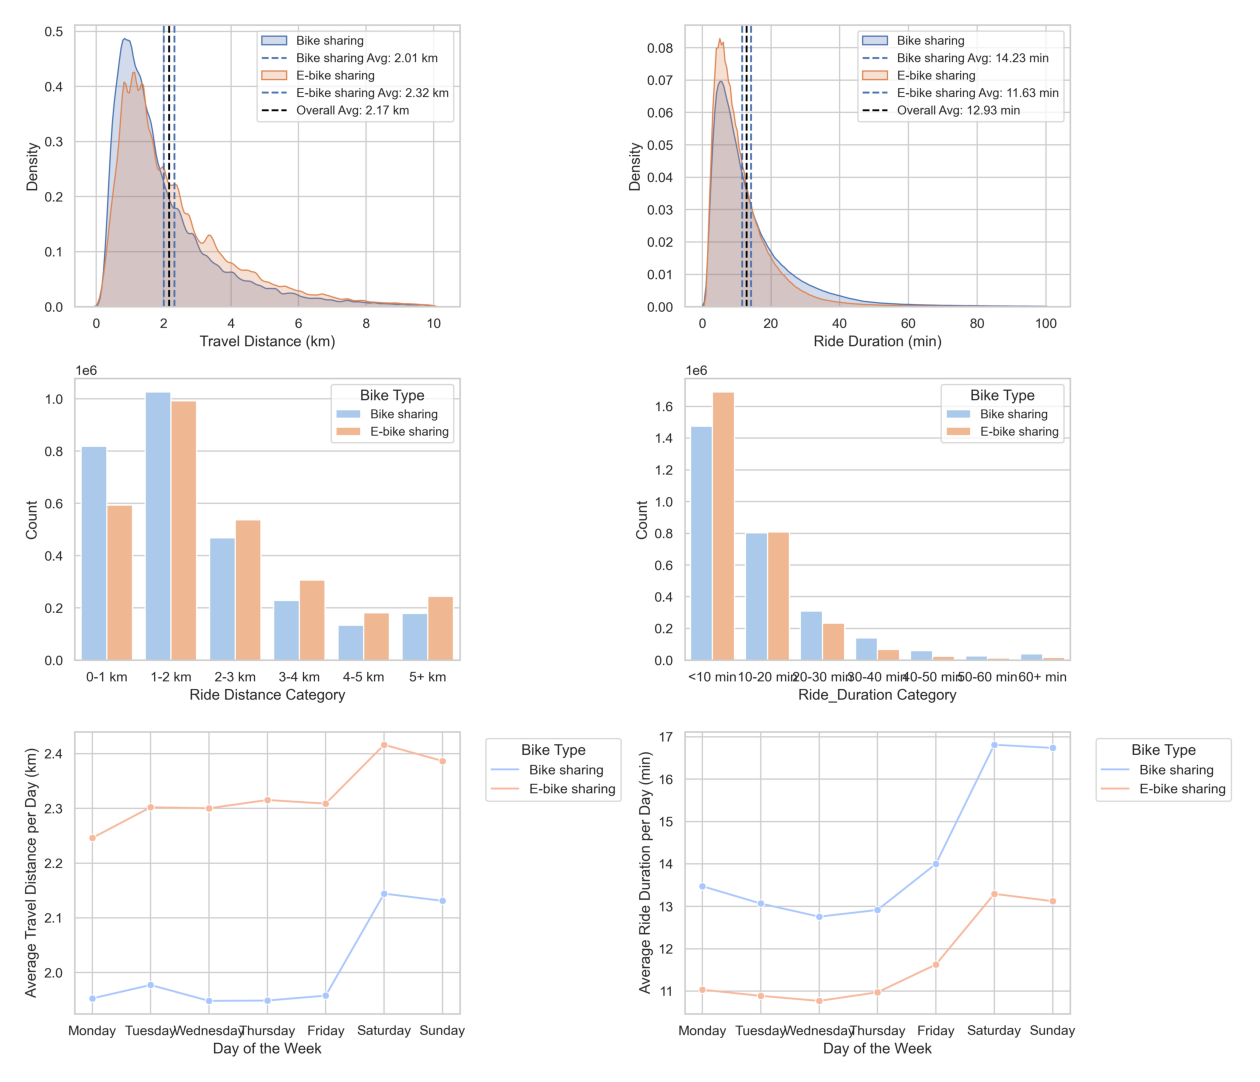

In [21]:
plt.figure(figsize=(16,16))
Fig_2 = Image.open('figure/Fig 2.png')
plt.imshow(Fig_2)
plt.axis('off')  
plt.show()

Fig. 2. Distribution of distance and duration of bike-sharing trips and the change over the week

### 3.2 Temporal features of travel pattern
The use of bike-sharing is closely related to human activities may show regular patterns, and temporal trends can be observed by visualising the daily or hourly riding volume from different time dimensions such as year, season, month, week, and day. 

From Fig. 3(A) the daily ride counts fluctuate significantly and show a clear cyclical pattern. The peak of ride counts occurs from June to August, and then decreases significantly in January, which may be due to seasonal factors. Combined with Fig. 3(B) we can clearly observe that there are more rides in the summer, less in the winter and similar in the spring and autumn. The outliers in the graph may be caused by atypical days or extreme weather. Fig. 3(C) shows that there are some fluctuations in the daily rides during a month, but the variation is not large and the daily rides are relatively balanced. In Fig. 3(D), it can be observed that the rides from Monday to Friday are relatively close and stable, while the rides on Saturday and Sunday are lower than those on weekdays and fluctuate more. This may be due to the different travel needs of people on weekdays versus weekends. For example, people may commute to work by bike on weekdays and less frequently on weekends. A further look at the distribution of hourly rides per day of the week (Fig. 3 E). The weekday pattern is similar, with two distinct peaks between 7.00 - 9.00 and 16.00 - 18.00, coinciding with the peak commuting hours. The pattern at weekends is quite different, with no distinct morning or evening peaks and relatively more riding in the afternoon, possibly reflecting a pattern of leisure activity. During the night time hours between 23:00 - 04:00, the amount of riding is relatively low each day, which corresponds to people's rest periods. The bike-sharing demand shows short- and long-term cycles such as weekday commuting patterns, weekend leisure patterns, and seasonal variations, and the time factor has a strong influence on the demand of bike-sharing.


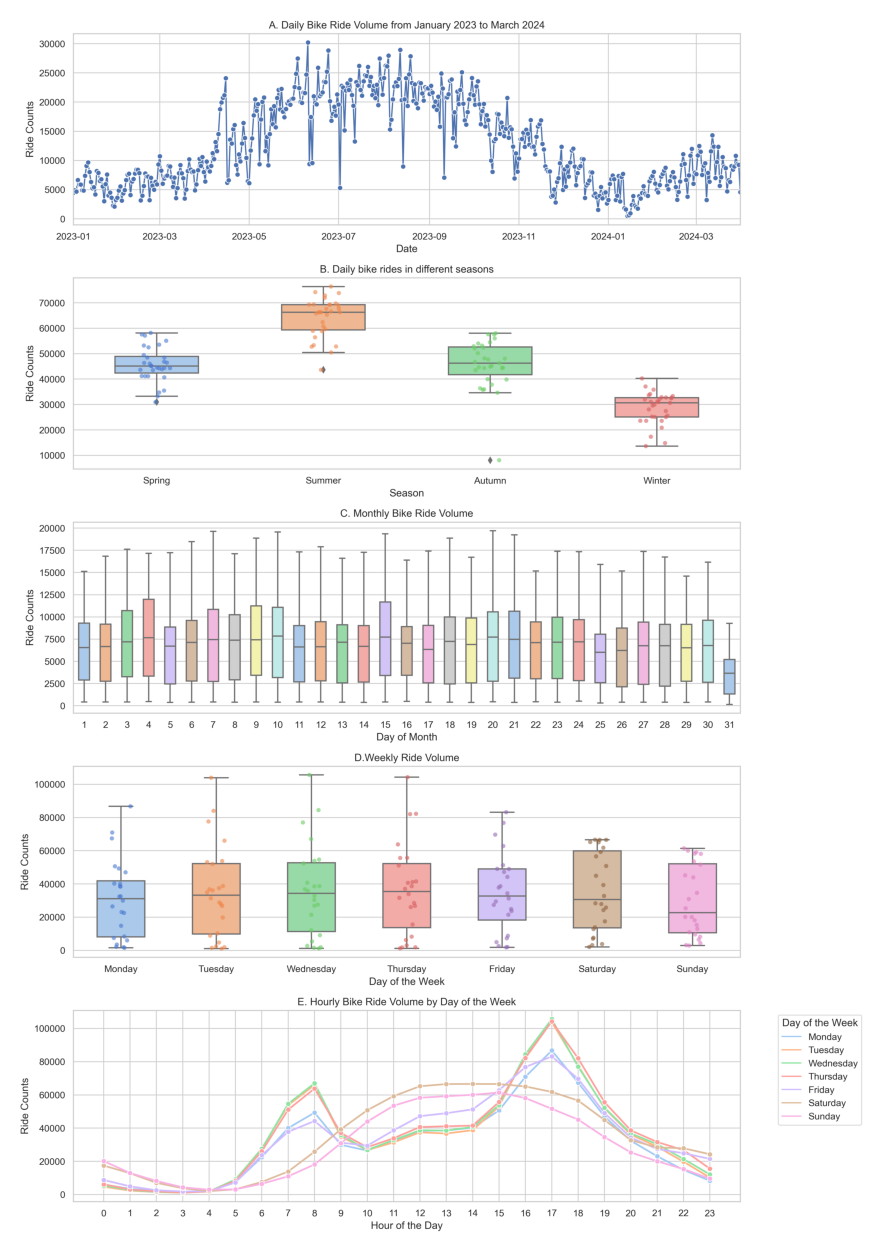

In [22]:
plt.figure(figsize=(16,16))
Fig_3 = Image.open('figure/Fig 3.png')
plt.imshow(Fig_3)
plt.axis('off')  
plt.show()

Fig. 3. Time distribution of bike-sharing trips

### 3.3 Spatial features of travel pattern
### 3.3.1 Spatial mobility
 In order to understand the spatial distribution of bike trips, we counted the number of spatial flows based on the origin and destination of the trip and plotted straight lines to represent this. Different colours are used to distinguish the amount of cycling, with darker colours representing approximately frequent cycling activity. From Figure 4, we can see that the spatial distribution shows a circle structure centred on the city centre. The city centre has frequent cycling activities due to its dense population and more bike-sharing stations. Although there are bicycle stations in the periphery of the city, the demand is low due to the remote location.


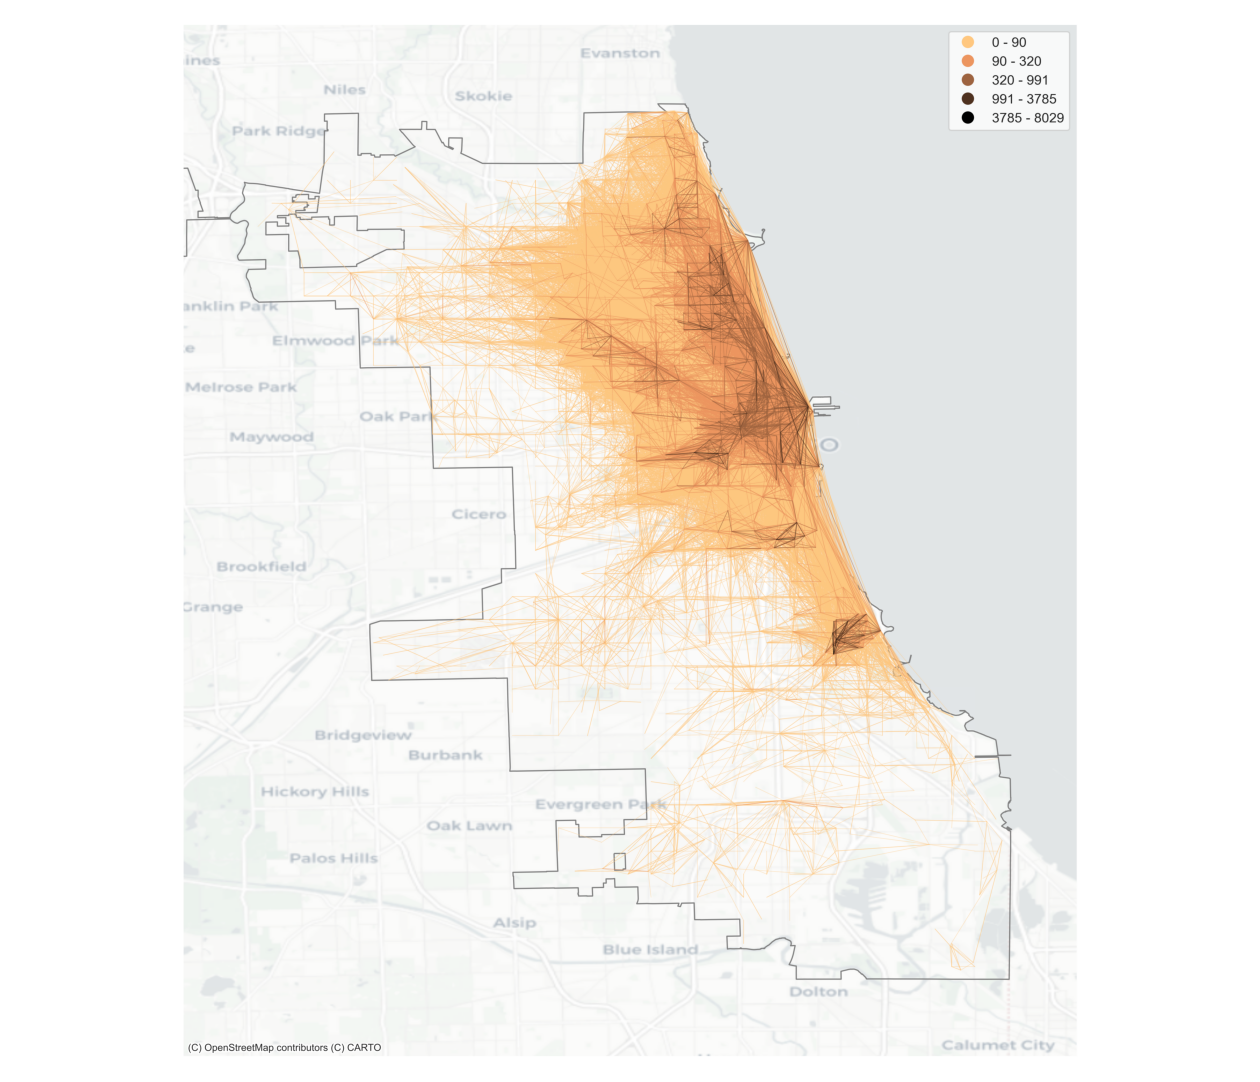

In [23]:
plt.figure(figsize=(16,16))
Fig_4 = Image.open('figure/Fig 4.png')
plt.imshow(Fig_4)
plt.axis('off')  
plt.show()

Fig. 4. Bike-sharing travel streams

### 3.3.2 Distribution of Start and End Stations
Based on the ride counts of each start and end station, we can identify the hotspot areas where trips occur. The top 10 start and end stations in terms of ride counts are shown in Fig. 5. As can be seen in Fig. 6, the city centre and its northern area have the most frequent cycling activity, with a small area of frequent cycling in the south. As the demand of bike-sharing has a clear commuting pattern, the distribution of start and end stations during the morning peak hour (7:00 - 9:00) shows a pattern of mobility from residential areas to work areas. The concentration area of start stations in the morning peak may correspond to residential communities, and the distribution of end stations in the morning peak is more concentrated in the city centre, where there are a large number of offices and businesses. Identifying hotspot areas for cycling at different times of the day will enable better adjustment of bike-sharing supply to meet public demand.


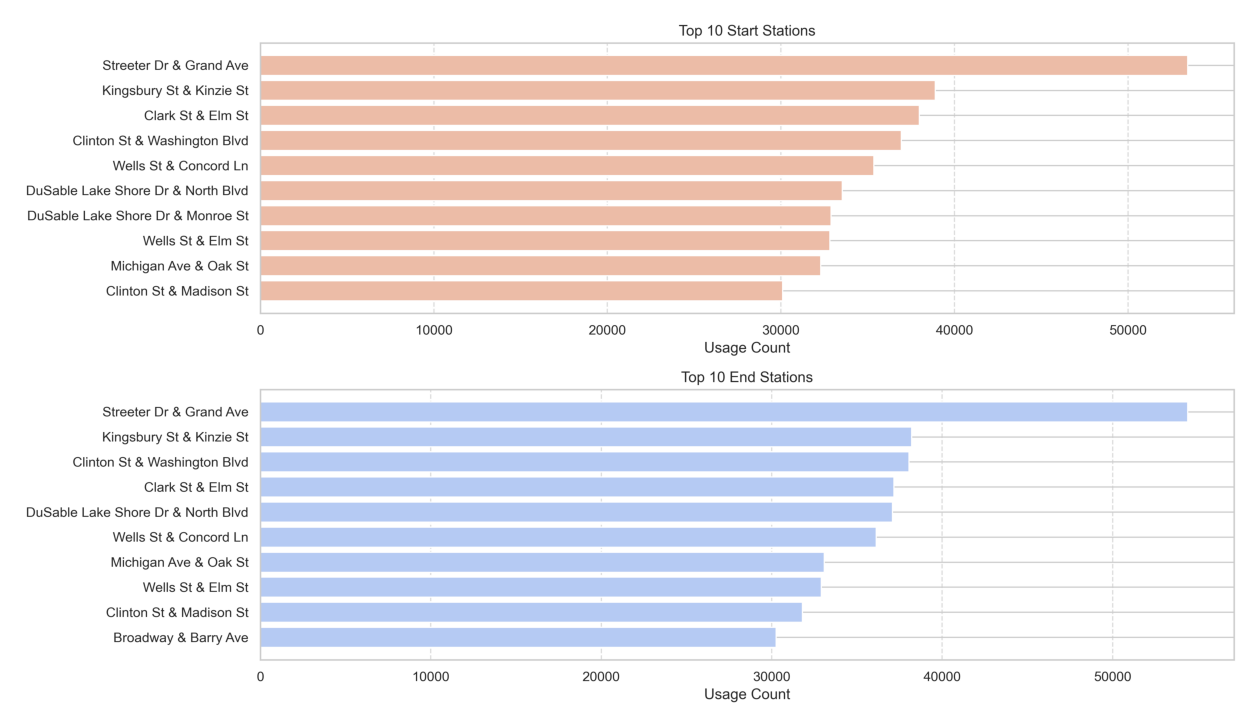

In [25]:
plt.figure(figsize=(16,16))
Fig_5 = Image.open('figure/Fig 5 Top 10 Start and End Stations by Usage.png')
plt.imshow(Fig_5)
plt.axis('off')  
plt.show()

Fig. 5. Top 10 Start and End Stations

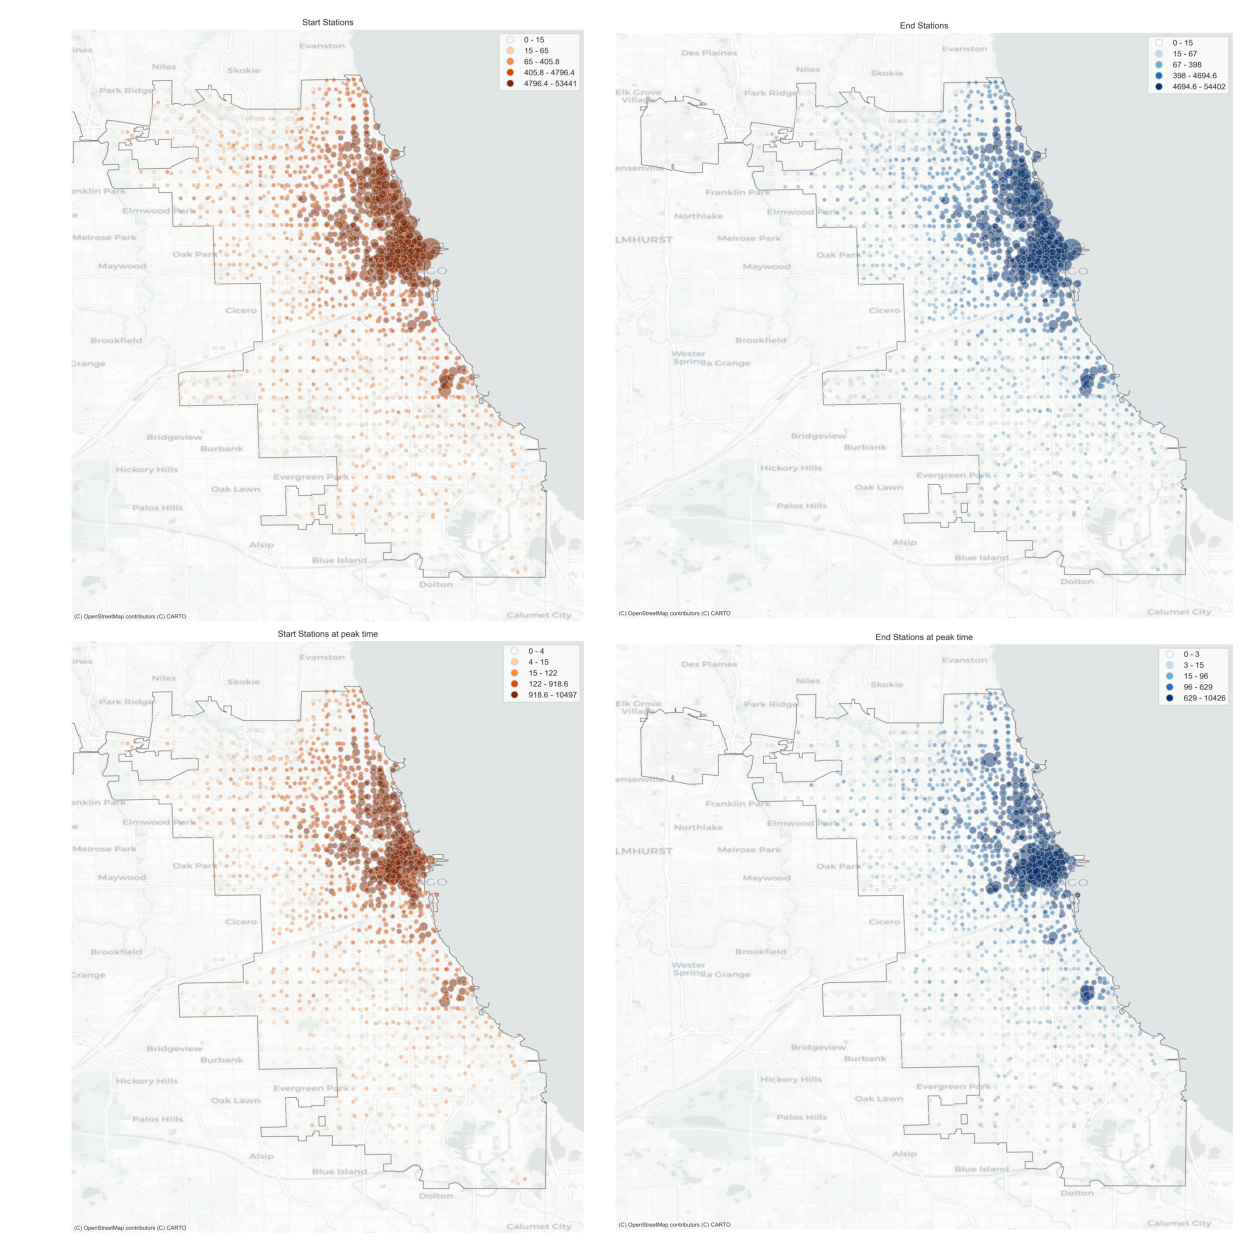

In [26]:
plt.figure(figsize=(16,16))
Fig_6 = Image.open('figure/Fig 6 Chicago Bike Share Station Usage Map_Start and End Stations.png')
plt.imshow(Fig_6)
plt.axis('off')  
plt.show()

Fig. 6. Hotspot map of bike-sharing station activity

### 3.3.3 Public transport factors
Bike-sharing is often used as a last-mile mode of transport for trips between public transport hubs, and proximity to public transport stations such as metro stations and bus stops can increase the demand for bicycles (Eren and Uz, 2020, pp. 10-12).Eren and Uz (2020, p. 13) also note in their study that the distance between bike-sharing stations distance is also one of the influencing factors and that a suitable buffer distance can increase the demand. In Figures 7 and 8, it can be seen that cycling activity around public transport stations is more frequent, and ride demand decreases as the distance between bike-sharing stations and the distance to bus and metro stations increases.


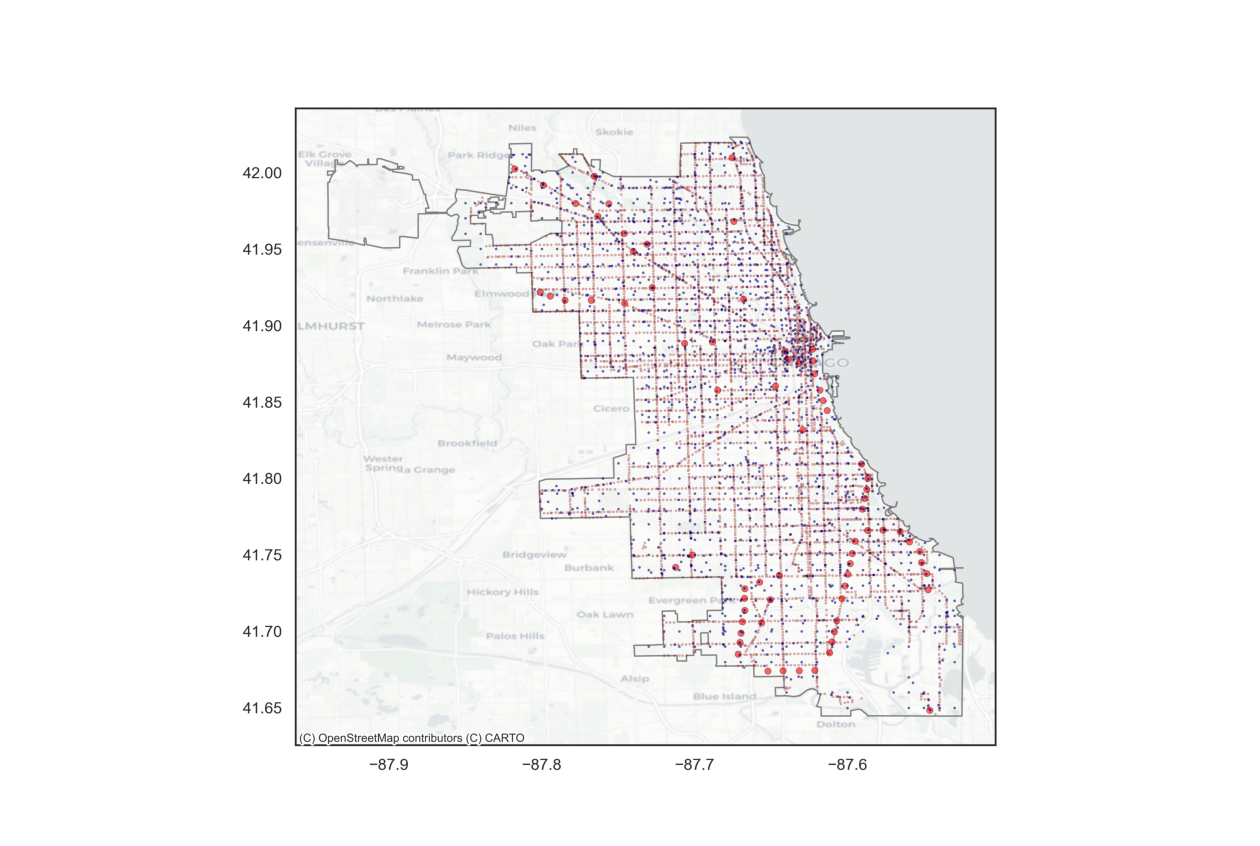

In [46]:
#from IPython.display import IFrame
#html_file_path = 'figure/Fig 7 heatmap_with_ride_count.html'
#IFrame(src=html_file_path, width=700, height=700)
plt.figure(figsize=(16,16))
Fig_7 = Image.open('figure/Fig 7.png')
plt.imshow(Fig_7)
plt.axis('off')  
plt.show()

Fig. 7. Cycling hotspots versus distribution of public transport stops

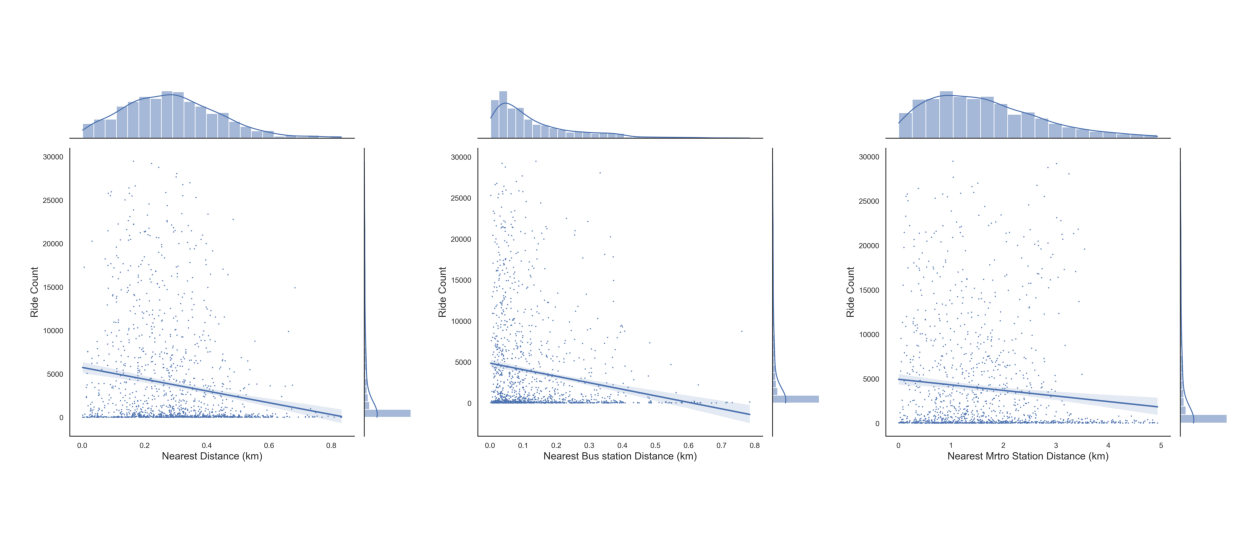

In [27]:
plt.figure(figsize=(16,16))
Fig_8 = Image.open('figure/Fig 8.png')
plt.imshow(Fig_8)
plt.axis('off')  
plt.show()

Fig. 8. Relationship between ride counts and distance to transport stations

### 3.4 Weather factors 
Weather conditions such as temperature, precipitation, and wind speed can affect bike-sharing demand to a large extent (Eren and Uz, 2020, pp. 4-6). The relationship between ride demand and different weather factors is in line with our expectations ( Fig. 9).  Temperature is positively correlated with riding demand, while precipitation, humidity and wind speed are negatively correlated, as rain, high humidity and high wind speed are not suitable for riding. The distribution of high ride demand is in the range of temperature 20°C to 30°C, humidity 50-70 %, and wind speed below 6 m/s.


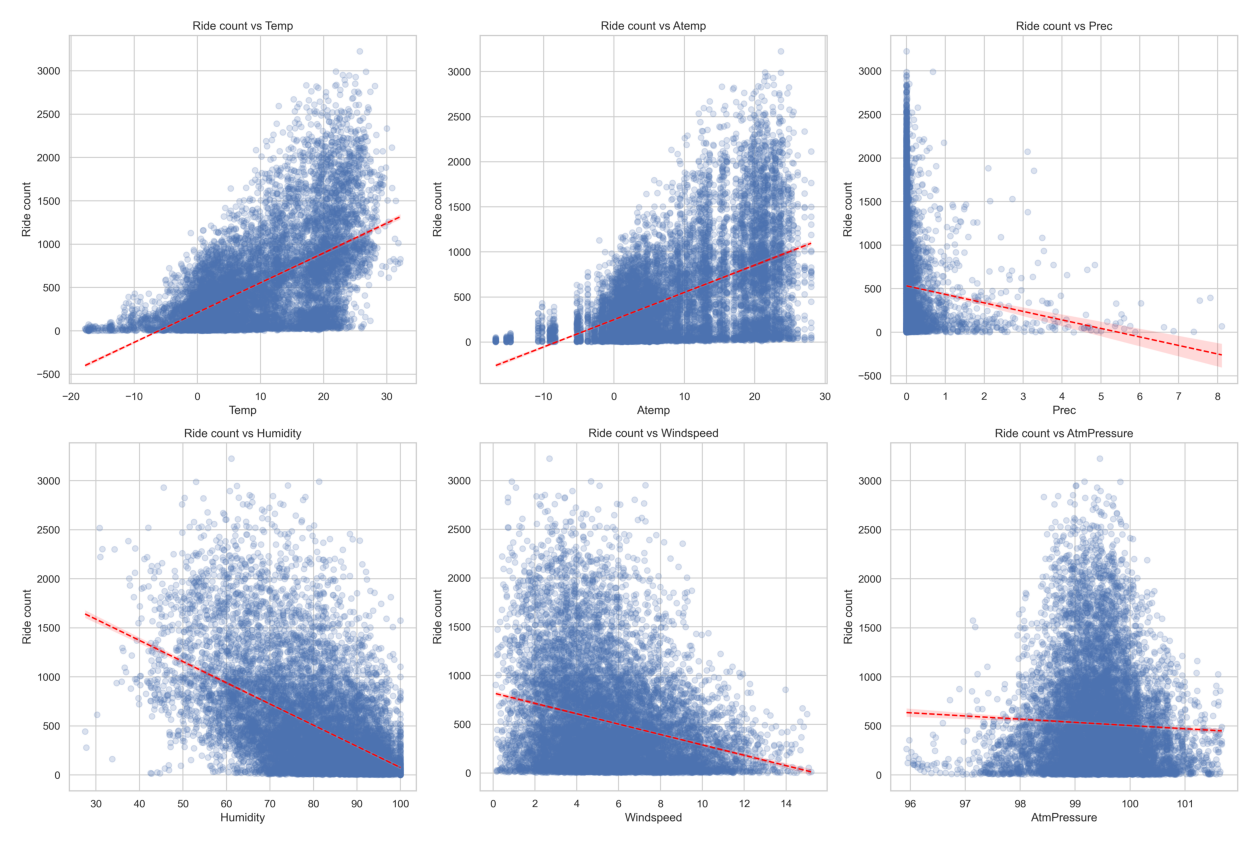

In [34]:
plt.figure(figsize=(16,16))
Fig_9 = Image.open('figure/Fig 9.png')
plt.imshow(Fig_9)
plt.axis('off')  
plt.show()

Fig. 9. Single Weather Variables and riding demand

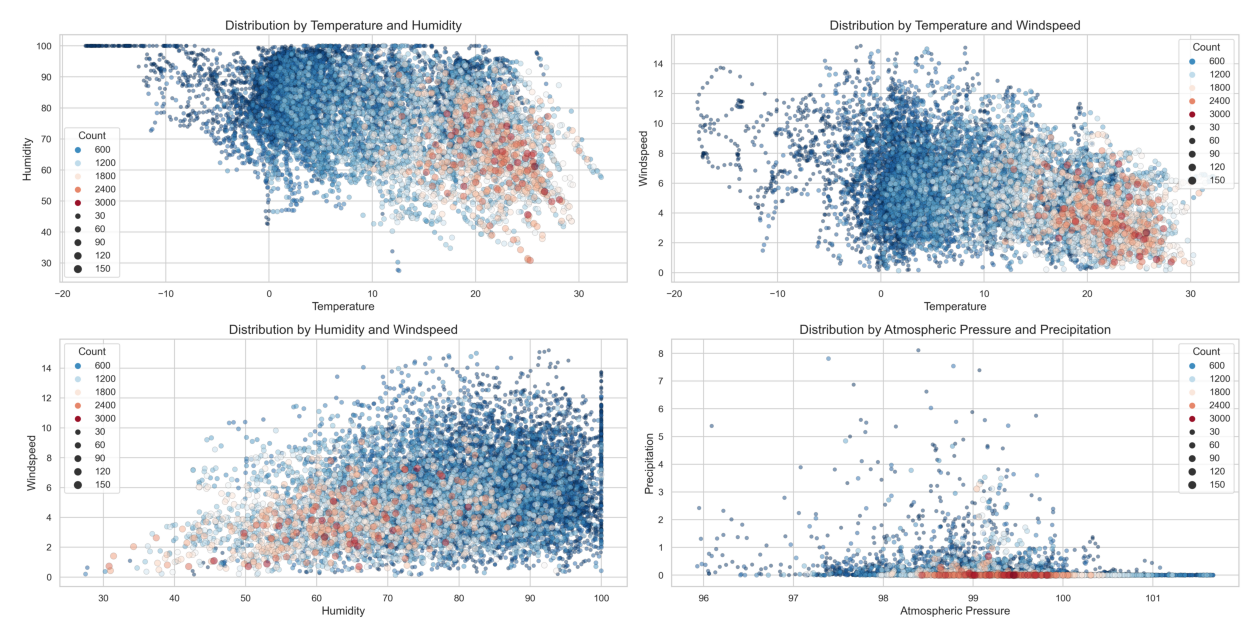

In [35]:
plt.figure(figsize=(16,16))
Fig_10 = Image.open('figure/Fig 10.png')
plt.imshow(Fig_10)
plt.axis('off')  
plt.show()

Fig. 10. Multiple weather variables and riding demand

## 4. Demand forecasting
There are many machine learning and deep learning models used for time series prediction, in this study lasso regression, Random Forests, XGBoost , Long Short-Term Memory (LSTM) are selected to achieve the prediction of hourly bicycle demand in Chicago.

### 4.1 Data processing
The dataset is adjusted to be suitable for prediction:
(1) Adjust the dataset according to the target variable "number of rides per hour", the dataset size is 10934;
(2) Add lagged variables. In time series analysis, past values may affect current values. The ride counts of the previous hour, the same hour of the previous day, the same hour of the previous week, and the temperature and precipitation of the next hour are added to the dataset;
(3) Variable transformation. Observing the distribution of each variable, the distribution of the target variable was highly skewed, log-transformed and standardised; precipitation was transformed into a binary variable to better identify its effects. Descriptive statistics of specific variables are shown in Table 6.
(4) Correlation check ( Fig. 11). The target variable has a strong positive correlation with the time-lagged variables, followed by temperature and hourly variables." day of week" has zero correlation with the target variable, but it remains in the dataset as we observed periodic variations in previous analyses;
(5) Split the training and test sets. For time series data random splitting is usually not performed. We used the data during 2023 as the training set (N = 8759) and the data from 1 January 2024 to 31 March 2023 as the test test set (N = 2175) in a generic ratio of 8:2.


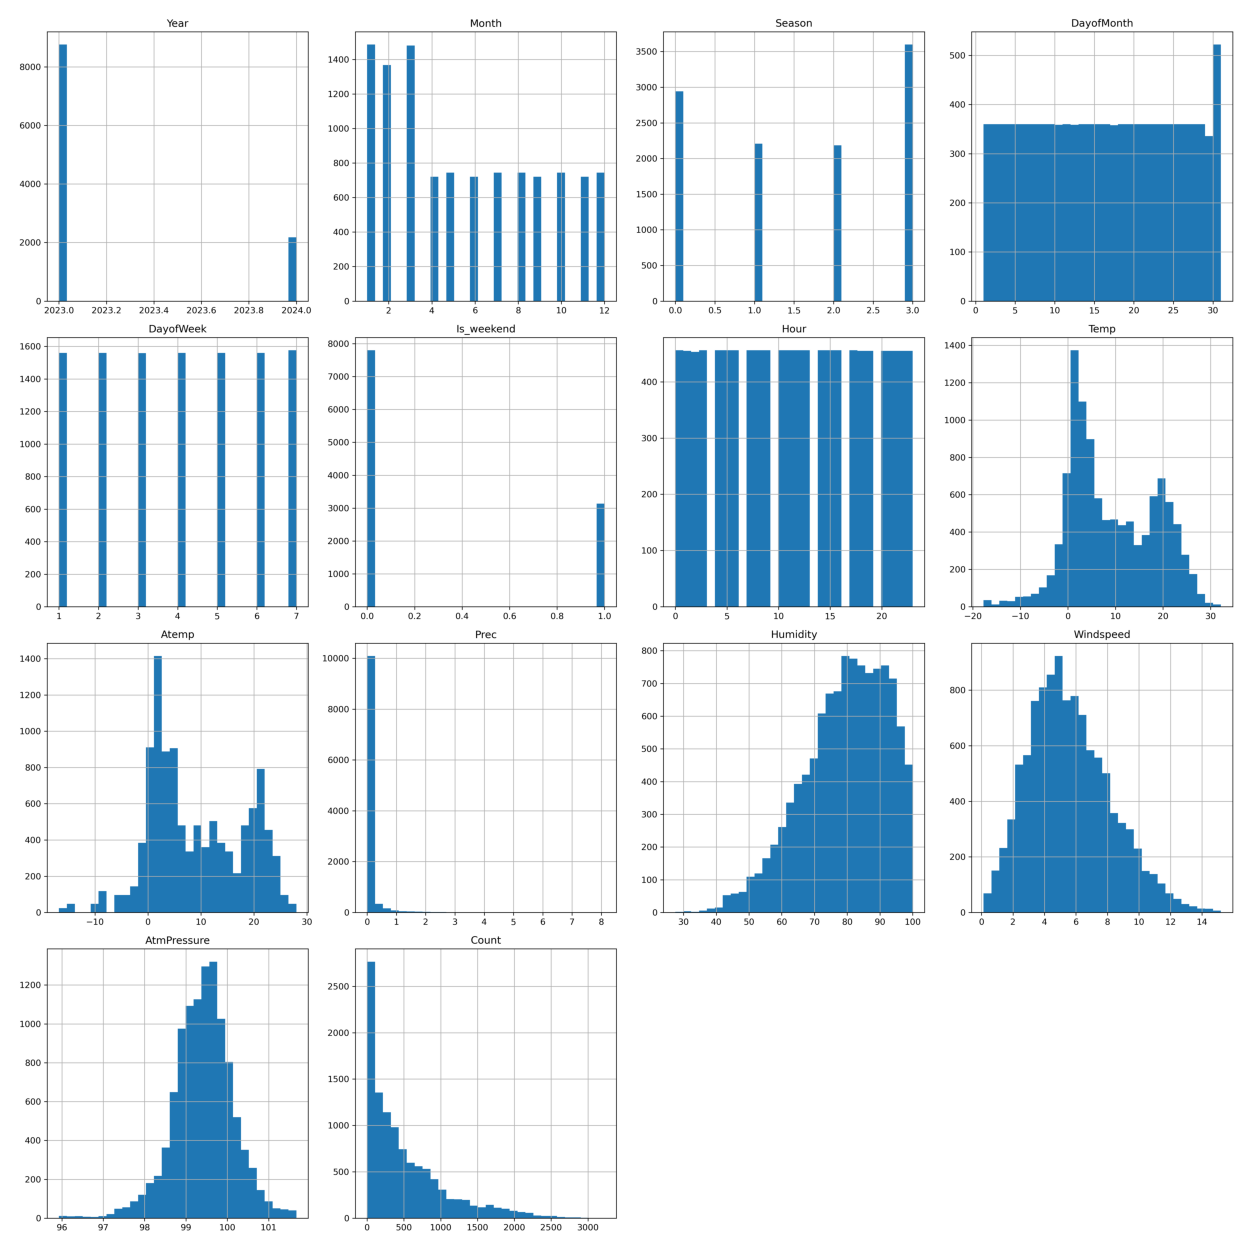

In [36]:
plt.figure(figsize=(16,16))
Fig_11 = Image.open('figure/Fig 11.png')
plt.imshow(Fig_11)
plt.axis('off')  
plt.show()

Fig. 11. Univariate distribution

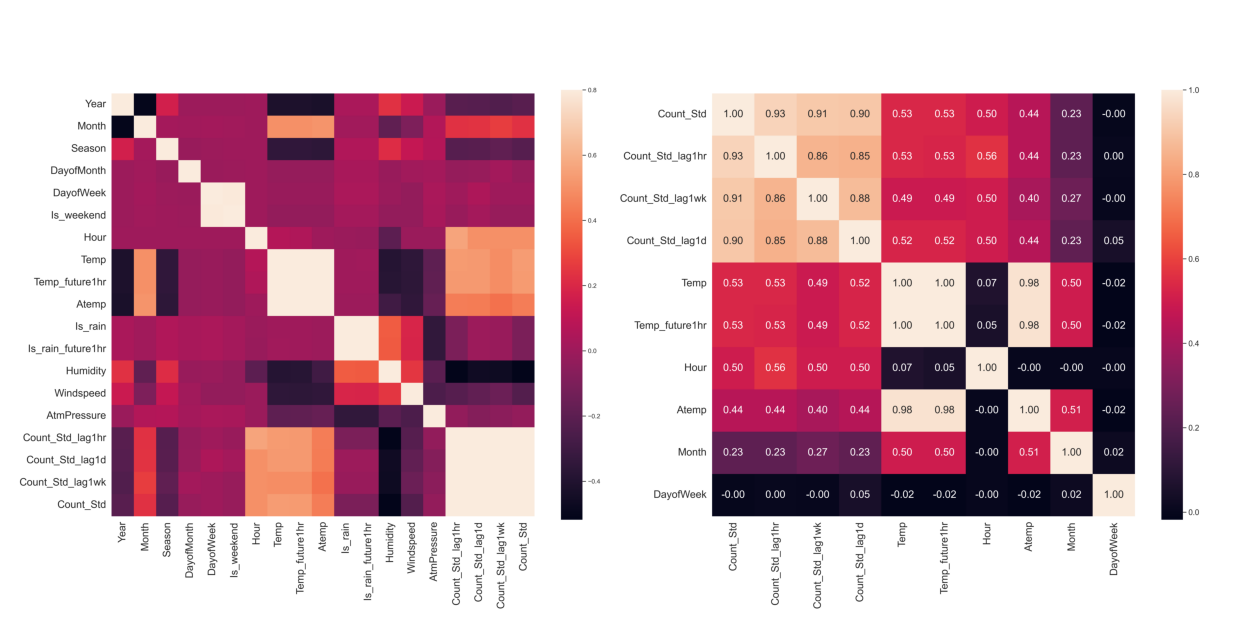

In [37]:
plt.figure(figsize=(16,16))
Fig_12 = Image.open('figure/Fig 12.png')
plt.imshow(Fig_12)
plt.axis('off')  
plt.show()

Fig. 12. Variable correlationm

### 4.2 Model parameterisation
For the machine learning approaches, GridSearchCV was used to determine the optimal parameters. In the lasso regression model set alpha to 0.1; in the Random Forest model set max featuressh = 30, n estimators = 50; in the XGBoost model set learning_rate = 0.1, max depth = 5, n_ estimator = 150; and finally in the LSTM model set Adam optimiser learning rate = 0.01, Batch Size = 16, Epoch = 100.

### 4.3 Results
In related studies (E, Park and Cho, 2020; Lin et al., 2024; Peláez-Rodríguez et al., 2024), R2, RMSE, MAPE, and MAE are commonly used as evaluation metrics for prediction model performance, and these metrics are also used in this study, and the specific results are shown in Table 6. The XGBoost model performs the best, outperforming the other models in all metrics, and the Random Forest performs well as well. LSTM performs the worst, with its MAPE as high as 603.389081%, which may produce great prediction errors in some cases. Therefore XGBoost and Random Forest may be more suitable models in this study. Specific prediction results for each model can be seen in Fig. 13.

In [3]:
results = pd.read_csv("model/results.csv")
results

Model        R2       MSE      RMSE     MAPE(%)       MAE
0          Lasso  0.889552  0.134968  0.367380  143.933751  0.287172
1  Random Forest  0.950079  0.061004  0.246990   77.495268  0.176057
2        XGBoost  0.966923  0.040421  0.201049   58.674910  0.148021
3           LSTM  0.856978  0.174775  0.418061  603.380981  0.319449

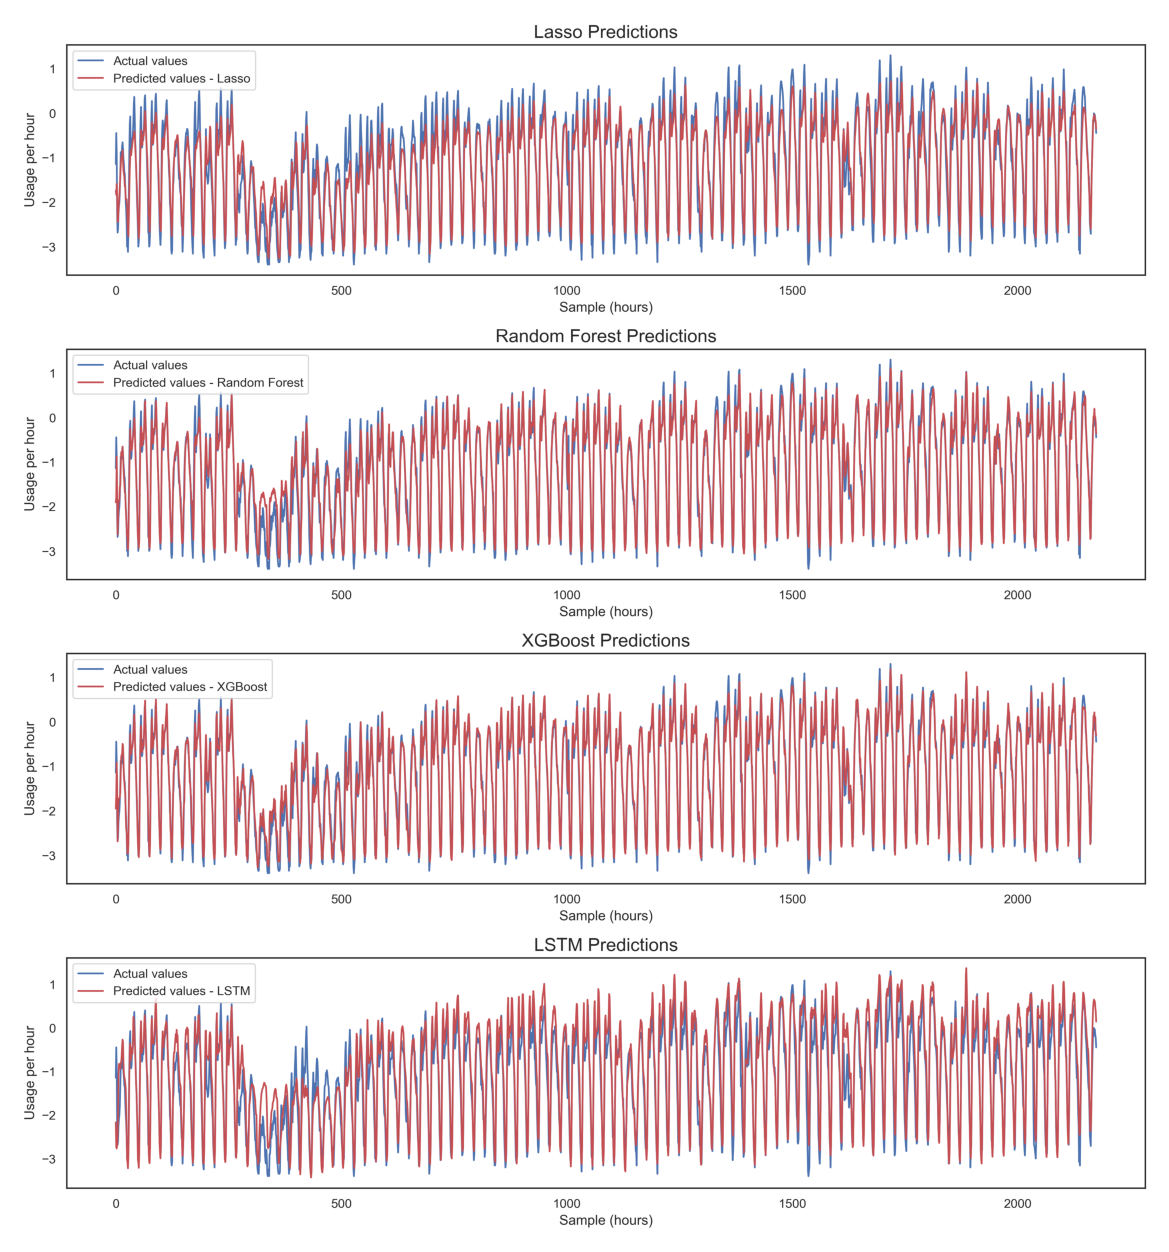

In [39]:
plt.figure(figsize=(16,16))
Fig_13 = Image.open('figure/Fig_13.png')
plt.imshow(Fig_13)
plt.axis('off')  
plt.show()

Fig. 13. Model prediction results

## 5. Discussion and conclusions
In this study, the collected data on bike-sharing in Chicago is integrated with other data into one dataset to analyse and visualise the results of bike-sharing usage patterns in both temporal and spatial dimensions. We find that the bike-sharing travel demand is cyclical in different time scales, such as seasonal variations and weekday commuting patterns, and this cyclicality reflects people's living habits and work patterns. The spatial distribution of bike-sharing demand shows a clear circle structure, with strong demand in the city centre and weak demand in the peripheral areas of the city, with obvious differences in demand. Areas close to public transport stations show stronger demand for use. In addition, we found a clear influence of weather factors such as temperature on bike-sharing travel patterns. Based on these factors, we also used a variety of ML and DL methods to predict the demand for bike-sharing.
The study has the same limitations. Firstly, some data with missing spatial information were simply removed during data cleaning, which would have been usable in temporal characterisation as well as forecasting. Second, urban environmental and socio-demographic factors have potential impacts on bike-sharing travel demand but were not included in the study; and lastly, the model developed is an overall demand forecast for the entire Chicago area, and it may be more practical to develop a station-level demand forecasting model in future studies.

Nonetheless, the results of the study were able to provide insights into urban transport planning and the management of bike-sharing services. By helping to develop a rational deployment strategy and optimise the layout of the bike-sharing system, the service can be more efficient and encourage more people to choose this eco-friendly travel option.

Word count: 3128

Data availability statement
The data and code related to this study are openly available on github at: https://github.com/YiXu2024/Exploring-spatio-temporal-travel-patterns-and-forecasting-demand-for-bike-sharing

## References
Bergman, Z., Allenspach, N. and Bergman, M.M. (2024) ‘A Tale of Two Divvys: The Bicycle Sharing System of Chicago’, Sustainability, 16(5), p. 2146. Available at: https://doi.org/10.3390/su16052146.

Chicago Metropolitan Agency for Planning. 2023, June 2. 2023 CTA Bus Stops [Online]. [Accessed 25 March 2023]. Available from: https://datahub.cmap.illinois.gov/datasets/CMAPGIS::2023-cta-bus-stops/about

Chicago Metropolitan Agency for Planning. 2024, February 23. 2023 Metra Rail Stations [Online]. [Accessed 25 March 2023]. Available from: https://datahub.cmap.illinois.gov/datasets/CMAPGIS::2023-metra-rail-stations/explore

Chicago Metropolitan Agency for Planning. 2024, February 23. Councils of Mayors Boundary Shapefile [Online]. [Accessed 25 March 2023]. Available from: https://datahub.cmap.illinois.gov/datasets/CMAPGIS::councils-of-mayors-boundary-shapefile-march-2013/about

Divvy bikes. 2024, March. Divvy Data [Online]. [Accessed 25 March 2023]. Available from: https://divvybikes.com/system-data

E, S.V., Park, J. and Cho, Y. (2020) ‘Using data mining techniques for bike sharing demand prediction in metropolitan city’, Computer Communications, 153, pp. 353–366. Available at: https://doi.org/10.1016/j.comcom.2020.02.007.

Eren, E. and Uz, V.E. (2020) ‘A review on bike-sharing: The factors affecting bike-sharing demand’, Sustainable Cities and Society, 54, p. 101882. Available at: https://doi.org/10.1016/j.scs.2019.101882.

Guidon, S., Reck, D.J. and Axhausen, K. (2020) ‘Expanding a(n) (electric) bicycle-sharing system to a new city: Prediction of demand with spatial regression and random forests’, Journal of Transport Geography, 84, p. 102692. Available at: https://doi.org/10.1016/j.jtrangeo.2020.102692.

Lin, H. et al. (2024) ‘Insights into Travel Pattern Analysis and Demand Prediction: A Data-Driven Approach in Bike-Sharing Systems’, Journal of Transportation Engineering, Part A: Systems, 150(2), p. 04023132. Available at: https://doi.org/10.1061/JTEPBS.TEENG-8137.

Peláez-Rodríguez, C. et al. (2024) ‘Bike sharing and cable car demand forecasting using machine learning and deep learning multivariate time series approaches’, Expert Systems with Applications, 238, p. 122264. Available at: https://doi.org/10.1016/j.eswa.2023.122264.
NASA POWER. 2024. meteorological data [Online]. [Accessed 25 March 2023]. Available from: https://power.larc.nasa.gov/
